In [45]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import Seq
from itertools import product
import re

from Bio import SeqIO
from Bio.SeqUtils import GC

sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
refGen = "plf82"
contig = 'UTI89'

In [4]:
def event_func(path):
    file_list = glob.glob((path+'/*_eventCounts.txt'))
    events_frame = pd.DataFrame({'S':[], 'SL':[], 'D':[], 'T':[], 'TL':[], 'L':[], 'Leaf':[], 'Name':[]})
    for file_name in file_list:
        events_frame_og = pd.read_table(file_name, sep=':', header=None, index_col=0).transpose()
        name = os.path.basename(file_name); name = name.split('_')[0]
        events_frame_og['Name'] = [name]
        events_frame = events_frame.append(events_frame_og)
    events_frame.reset_index(drop=True, inplace=True)
    events_frame['AT'] = events_frame['T'] + events_frame['TL']
    return events_frame

In [5]:
events_frame = event_func("Results/geneRaxResults/reconciliations")

In [6]:
ortho = pd.read_table('Results/Orthogroups.GeneCount.tsv', sep = '\t')

In [7]:
ortho.Total.sum()

336

In [8]:
ortho_bool = ortho.iloc[:, 1:-1].astype(bool).astype(int)
ortho_bool["amount"] = ortho_bool.sum(axis=1)
ortho_bool['Orthogroup'] = ortho['Orthogroup']

amount = [int(ortho_bool[ortho_bool.Orthogroup==i]['amount']) for i in events_frame.Name]
events_frame['amount'] = amount
total = [int(ortho[ortho.Orthogroup==i]['Total']) for i in events_frame.Name]
events_frame['total'] = total

<AxesSubplot:xlabel='amount', ylabel='AT'>

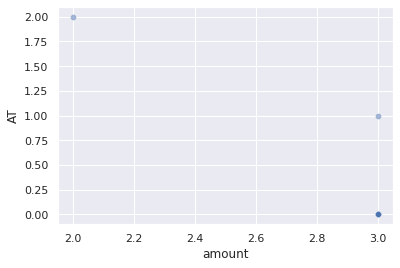

In [9]:
sns.scatterplot(x=events_frame.amount, y=events_frame.AT, alpha = 0.5)
#plt.ylim([0,200])

<AxesSubplot:xlabel='amount', ylabel='Count'>

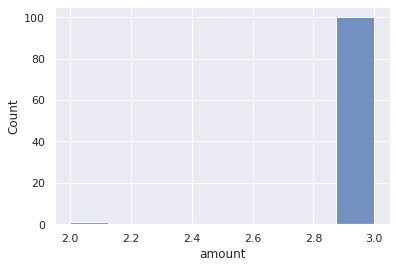

In [10]:
sns.histplot(events_frame.amount)

# Coordinate distribution of AT

In [12]:
ortho = pd.read_table('Results/Orthogroups.txt', sep = ':', header = None)
ortho = ortho.rename({0: 'og', 1: 'genes'}, axis='columns')


allTransfers = []
ogs = []
start_loc = []
end_loc = []
amount = []
total = []
genes_list = []
for og in events_frame.Name:
    genes = ortho[ortho.og == og]['genes'].values[0].split(' ')
    for gene in genes[1:]:
        if gene.split('|')[0] == refGen:
            allTransfers.append(int(events_frame[events_frame.Name == og]['AT']))
            ogs.append(og)
            start_loc.append(int(gene.split('|')[4]))
            end_loc.append(int(gene.split('|')[5]))
            genes_list.append(gene.split('|')[2])
            amount.append(int(events_frame[events_frame.Name == og]['amount']))
            total.append(int(events_frame[events_frame.Name == og]['total']))
loc_df = pd.DataFrame({'og':ogs, 'gene':genes_list, 'start_loc': start_loc, 'end_loc':end_loc, 'AT':allTransfers, 'amount':amount, 'total': total})

In [13]:
loc_df = loc_df.sort_values('start_loc')

<AxesSubplot:xlabel='AT', ylabel='Count'>

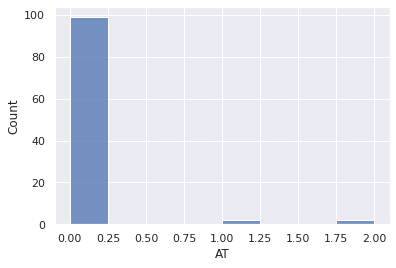

In [14]:
sns.histplot(x=loc_df.AT)

<AxesSubplot:xlabel='start_loc', ylabel='AT'>

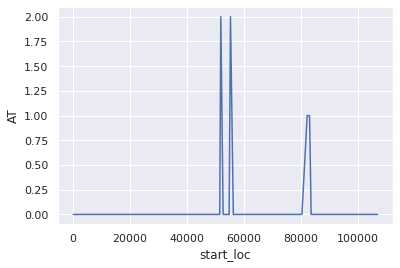

In [15]:
sns.lineplot(x=loc_df.start_loc, y=loc_df.AT)

<AxesSubplot:xlabel='start_loc'>

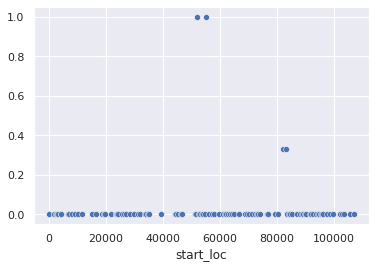

In [16]:
sns.scatterplot(x=loc_df.start_loc, y=loc_df.AT/loc_df.amount)

<AxesSubplot:xlabel='total', ylabel='AT'>

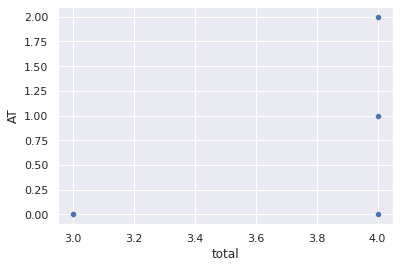

In [17]:
sns.scatterplot(x=loc_df.total, y=loc_df.AT)

# Restriction sites

In [39]:
def extend_ambiguous_dna(seq):
    d = {'A':'A', 'T':'T', 'C':'C', 'G':'G',
        'W':'[W|A|T]', 'S':'[S|G|C]', 'M': '[M|A|C]', 'K': '[K|G|T]', 'R':'[R|A|G]', 'Y': '[Y|C|T]',
        'B':'[B|C|T|G]', 'D': '[D|A|T|G]', 'H': '[H|A|C|T]', 'V':'[V|A|C|G]',
        'N':'.'}
    r = ''
    for i in seq:
        r+=d[i]
    return r 

In [55]:
def find_restriction_sites(restriciton_sites, genome):
    r = []
    for pattern in restriciton_sites:
        results = re.finditer(pattern, genome)
        for result in results:
            r.append(result.span()[0])
    r.sort()
    return r

In [41]:
restriction_sites=['GAGCTC ', 'CACGTG ', 'CGGCCG ', 'CCTNAGG ', 'GGTCTC ', 'CCTNNNNNAGG ', 'TACGTA ', 'RGGNCCY ', 'AGGCCT ', 'GRGCYC ', 'GRGCYC ','GAATTC ',
 'AGCGCT ',
 'ATGCAT ',
 'CCWWGG ',
 'CCWWGG ',
 'CYCGRG ',
 'GGTNACC ',
 'GGTNACC ',
 'GATATC ',
 'GATATC ',
 'GGWCC ',
 'CTGAAG ',
 'CTGRAG ',
 'CCWGG ']
restriction_sites = [i.rstrip() for i in restriction_sites]

In [42]:
restriciton_sites = [extend_ambiguous_dna(i) for i in restriction_sites]

In [43]:
restriciton_sites

['GAGCTC',
 'CACGTG',
 'CGGCCG',
 'CCT.AGG',
 'GGTCTC',
 'CCT.....AGG',
 'TACGTA',
 '[R|A|G]GG.CC[Y|C|T]',
 'AGGCCT',
 'G[R|A|G]GC[Y|C|T]C',
 'G[R|A|G]GC[Y|C|T]C',
 'GAATTC',
 'AGCGCT',
 'ATGCAT',
 'CC[W|A|T][W|A|T]GG',
 'CC[W|A|T][W|A|T]GG',
 'C[Y|C|T]CG[R|A|G]G',
 'GGT.ACC',
 'GGT.ACC',
 'GATATC',
 'GATATC',
 'GG[W|A|T]CC',
 'CTGAAG',
 'CTG[R|A|G]AG',
 'CC[W|A|T]GG']

In [57]:
restriction_coordinates = find_restriction_sites(restriciton_sites, str(record.seq))

<AxesSubplot:ylabel='Count'>

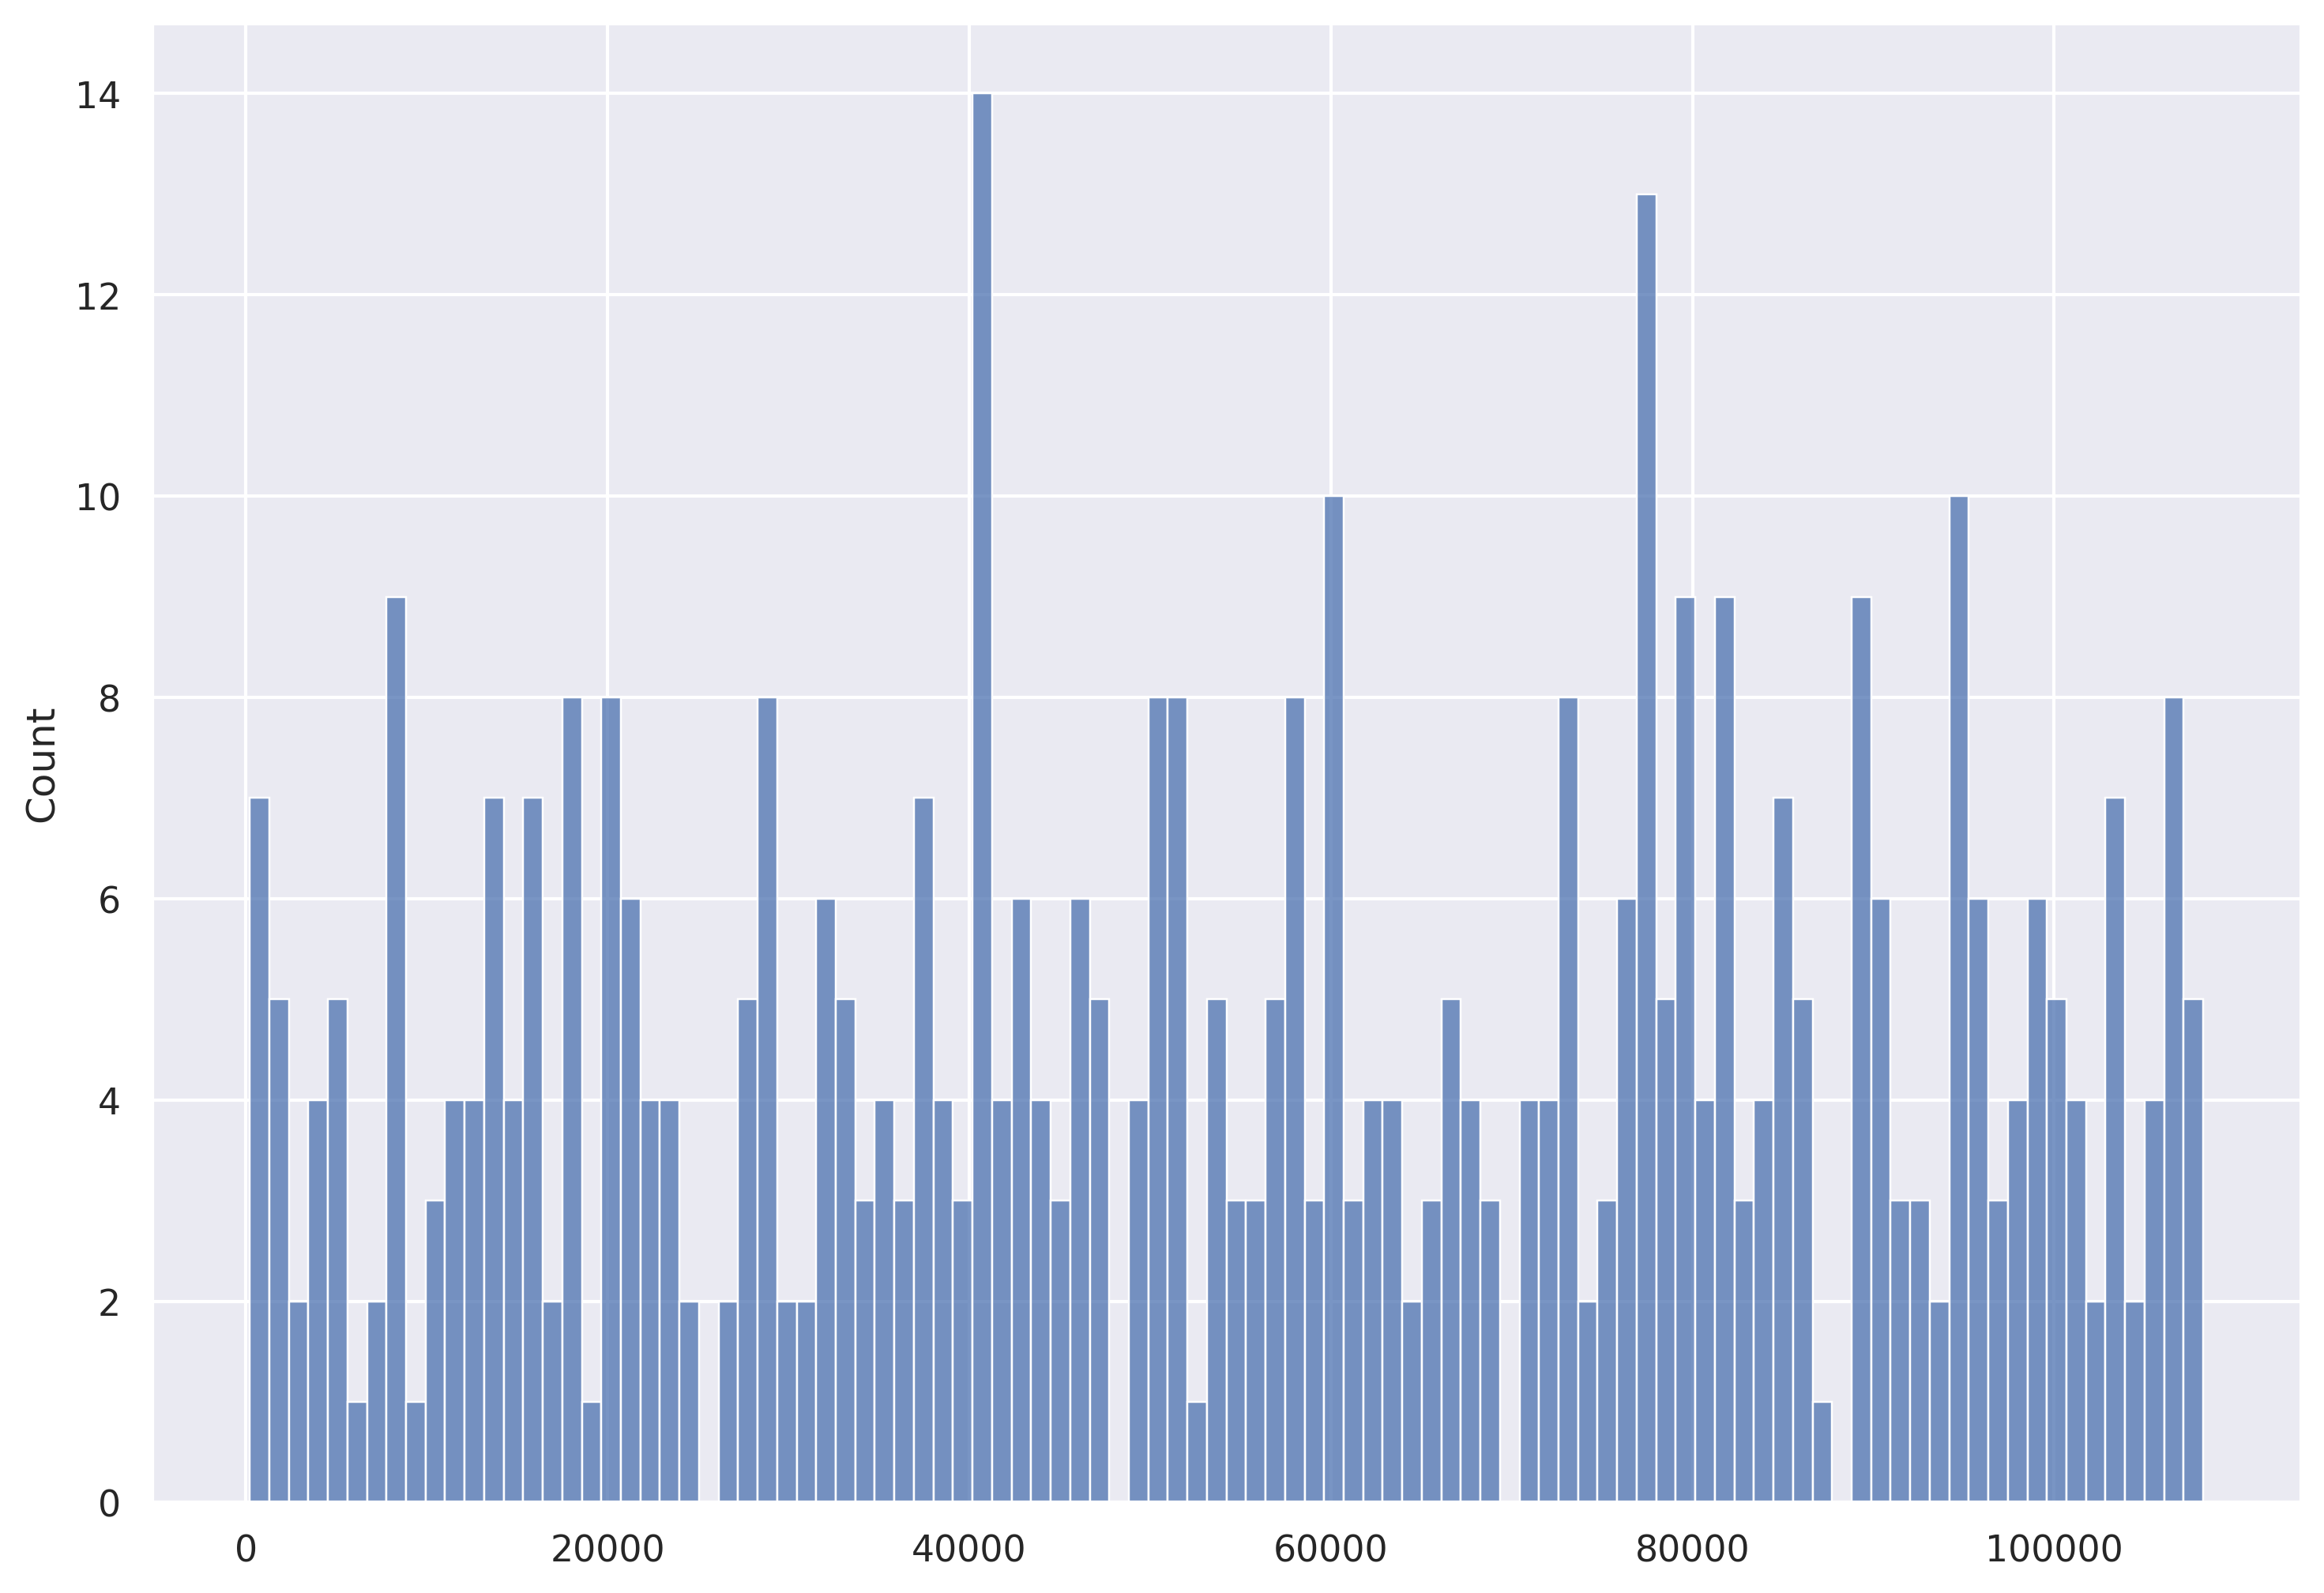

In [59]:
sns.histplot(restriction_coordinates, bins = 100)

# Recombinations

In [19]:
reads = pd.read_table('Results/{contig}.bed'.format(contig=contig), sep = '\t', header = None)

In [20]:
reads = reads.iloc[:, [1,2]]
reads = reads.rename({1: 'start', 2: 'end'}, axis='columns')

#add 1 to values because they are written from 0 in the bed file
reads.loc[:, 'start'] = reads['start'].apply(lambda x: x+1)
reads.loc[:, 'end'] = reads['end'].apply(lambda x: x+1)

In [21]:
depth_frame = pd.read_table('Results/depth{contig}.tsv'.format(contig=contig), sep = '\t', header = None)
depth_frame = depth_frame.rename({0: 'gene', 1: 'coordinate', 2: 'depth'}, axis='columns')

In [22]:
comp_file_name = glob.glob('Results/gcb_res/{refGen}/window_complexity_contig_*'.format(refGen=refGen))[0]
comp = pd.read_table(comp_file_name, sep='\t')
comp['start'] = comp.position.apply(lambda x : x.split(':')[0])
comp['start'] = comp['start'].astype(float)
comp['end'] = comp.position.apply(lambda x : x.split(':')[1])
comp['end'] = comp['end'].astype(float)
comp = comp.drop('position', axis=1)
comp['complexity'] = comp['complexity'].astype(float)
comp = comp.sort_values('start')

In [23]:
reads_max_end = int(reads['end'][-1:])
comp_max_end = int(comp['end'][-1:])
max_end = min(reads_max_end,comp_max_end)

In [1]:
score_list = []
GC_list = []
window_oversize = 9000
record = SeqIO.read('recombinations/{genome}.fna'.format(genome=refGen), "fasta")
for index, row in comp.iterrows():
    start = int(row['start']) - window_oversize if int(row['start']) - window_oversize > 0 else 0
    end = int(row['end']) + window_oversize if int(row['end']) + window_oversize < max_end else max_end
    if end > max_end:
        break
    number = reads[(reads['start'] > start) & (reads['start'] <= end)].shape[0] + reads[(reads['end'] > start) & (reads['end'] <= end)].shape[0]
    depth = depth_frame[(depth_frame.coordinate > start) & (depth_frame.coordinate <= end)]['depth'].mean()
    score_list.append(number/depth)
    GC_list.append(GC(record.seq[start:end]))
comp = comp.iloc[0: min(len(comp), len(GC_list)), :]
comp['score'] = score_list
comp['GC'] = GC_list

NameError: name 'SeqIO' is not defined

In [1]:
sns.lineplot(x=comp.start, y=comp.complexity + 3)
sns.lineplot(x=comp.start, y=comp.score*0.8 + 1.5)
sns.lineplot(x=comp.start, y=comp.GC*0.05 - 2)

NameError: name 'sns' is not defined

<AxesSubplot:xlabel='start', ylabel='complexity'>

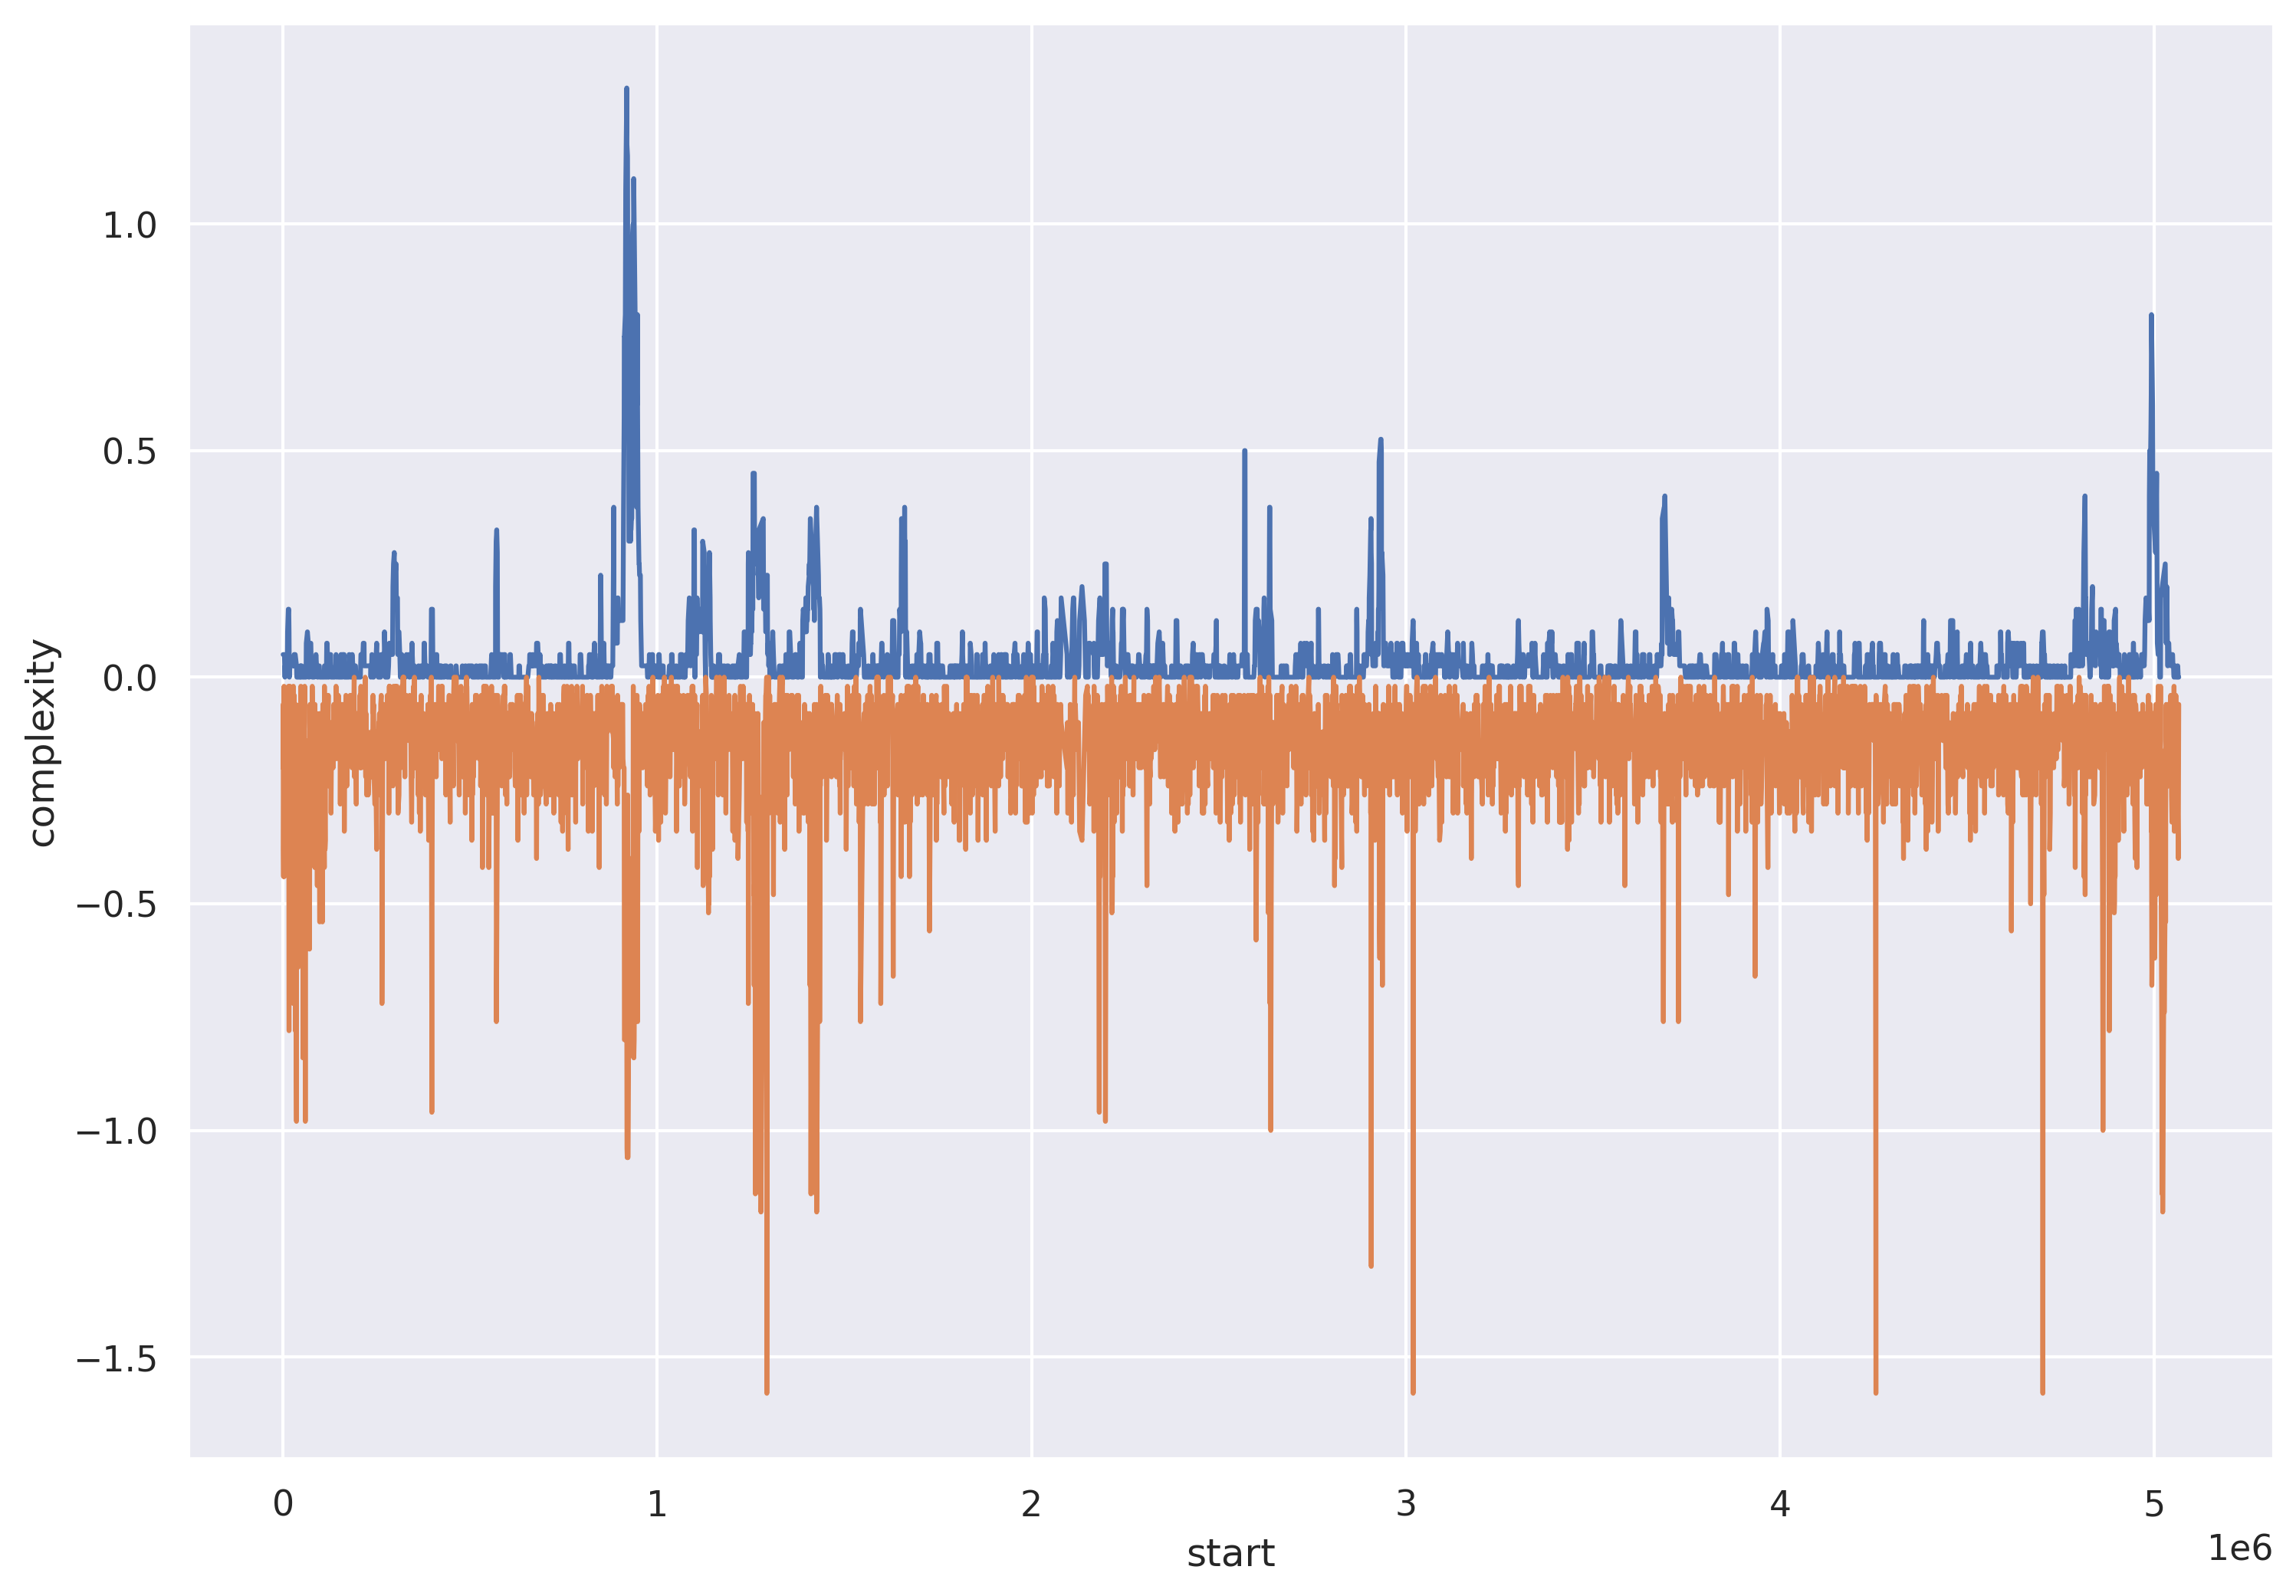

In [29]:
sns.lineplot(x=comp.start, y=comp.complexity)
sns.lineplot(x=loc_df.start_loc, y=-loc_df.AT * 0.02)

In [32]:
comp.to_csv('Results/{contig}comp.csv'.format(contig=contig))